In [1]:
import numpy as np
import os

# 定义数据文件路径 (根据你的实际环境修改，如果是 Kaggle 可能是 /kaggle/working/...)
PATH_NSL = '/kaggle/input/day4-data-cleaning-pipeline/nsl_kdd_processed.npz'
PATH_CIC = '/kaggle/input/day4-data-cleaning-pipeline/cic_ids_processed.npz'

def load_and_inspect(filepath, dataset_name):
    print(f"\n{'='*20} 正在检查数据集: {dataset_name} {'='*20}")
    
    # 1. 检查文件是否存在
    if not os.path.exists(filepath):
        print(f"❌ 错误: 找不到文件 {filepath}")
        return None, None, None, None
    
    # 2. 加载 .npz 文件
    try:
        data = np.load(filepath, allow_pickle=True)
        # 打印压缩包里都有哪些数组名 (预期: X_train, y_train, X_test, y_test, ...)
        print(f"📦 文件包含的数组键值: {list(data.keys())}")
        
        # 提取数据 (假设 Day 4 保存的键名如下)
        X_train, y_train = data['X_train'], data['y_train']
        X_test, y_test = data['X_test'], data['y_test']
        
        # 如果有验证集也可以提取，但在 Baseline 阶段主要用 Train/Test
        # X_val, y_val = data['X_val'], data['y_val'] 
        
    except Exception as e:
        print(f"❌ 加载失败: {e}")
        return None, None, None, None

    # 3. 维度形状检查 (Shape Check)
    print(f"\n--- 📏 维度检查 ---")
    print(f"Train Set: X={X_train.shape}, y={y_train.shape}")
    print(f"Test Set:  X={X_test.shape},  y={y_test.shape}")
    
    # 4. 特征数量验证
    n_features = X_train.shape[1]
    print(f"👉 特征数量 (Feature Count): {n_features}")
    
    # 5. 标签分布检查 (Class Balance)
    print(f"\n--- ⚖️ 标签分布 (Train) ---")
    unique, counts = np.unique(y_train, return_counts=True)
    total = len(y_train)
    for label, count in zip(unique, counts):
        pct = (count / total) * 100
        label_name = "正常 (Normal)" if label == 0 else "攻击 (Attack)"
        print(f"Label {label} ({label_name}): \t{count} 样本 ({pct:.2f}%)")

    # 6. NaN/Inf 残留检查 (Sanity Check)
    # 只需要检查一部分，避免计算太慢
    if np.isnan(X_train).any():
        print("❌ 警告: X_train 中发现 NaN 值！请回溯 Day 4 清洗步骤。")
    else:
        print("✅ 检查通过: X_train 中无 NaN。")
        
    if np.isinf(X_train).any():
        print("❌ 警告: X_train 中发现 Infinity 值！请回溯 Day 4 清洗步骤。")
    else:
        print("✅ 检查通过: X_train 中无 Infinity。")
        
    return X_train, y_train, X_test, y_test

# --- 执行检查 ---
print("🚀 开始 Day 5 数据自检程序...")

# 加载 NSL-KDD
X_train_nsl, y_train_nsl, X_test_nsl, y_test_nsl = load_and_inspect(PATH_NSL, "NSL-KDD")

# 加载 CIC-IDS-2017
X_train_cic, y_train_cic, X_test_cic, y_test_cic = load_and_inspect(PATH_CIC, "CIC-IDS-2017")

🚀 开始 Day 5 数据自检程序...

==================== 正在检查数据集: NSL-KDD ====================
📦 文件包含的数组键值: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']

--- 📏 维度检查 ---
Train Set: X=(113375, 122), y=(113375,)
Test Set:  X=(22544, 122),  y=(22544,)
👉 特征数量 (Feature Count): 122

--- ⚖️ 标签分布 (Train) ---
Label 0 (正常 (Normal)): 	60608 样本 (53.46%)
Label 1 (攻击 (Attack)): 	52767 样本 (46.54%)
✅ 检查通过: X_train 中无 NaN。
✅ 检查通过: X_train 中无 Infinity。

==================== 正在检查数据集: CIC-IDS-2017 ====================
📦 文件包含的数组键值: ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']

--- 📏 维度检查 ---
Train Set: X=(1764525, 51), y=(1764525,)
Test Set:  X=(504151, 51),  y=(504151,)
👉 特征数量 (Feature Count): 51

--- ⚖️ 标签分布 (Train) ---
Label 0 (正常 (Normal)): 	1466539 样本 (83.11%)
Label 1 (攻击 (Attack)): 	297986 样本 (16.89%)
✅ 检查通过: X_train 中无 NaN。
✅ 检查通过: X_train 中无 Infinity。


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# 设置绘图风格
sns.set_context("notebook")
%matplotlib inline

def evaluate_model(model, X_test, y_test, model_name="Model", class_names=['Normal', 'Attack']):
    print(f"\n{'='*20} EVALUATION: {model_name} {'='*20}")
    
    # 1. 预测
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    # 2. 打印指标
    acc = accuracy_score(y_test, y_pred)
    print(f"⏱️ Inference Time: {end_time - start_time:.4f} sec")
    print(f"🏆 Accuracy: {acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    
    # 3. 绘制混淆矩阵 (英文版)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return y_pred

🚀 开始训练 NSL-KDD 随机森林模型 (请稍候)...
✅ 训练完成！

==================== EVALUATION: RandomForest - NSL-KDD ====================
⏱️ Inference Time: 0.1043 sec
🏆 Accuracy: 0.7687

📝 Classification Report:
              precision    recall  f1-score   support

      Normal     0.6562    0.9724    0.7836      9711
      Attack     0.9671    0.6145    0.7515     12833

    accuracy                         0.7687     22544
   macro avg     0.8117    0.7935    0.7676     22544
weighted avg     0.8332    0.7687    0.7653     22544



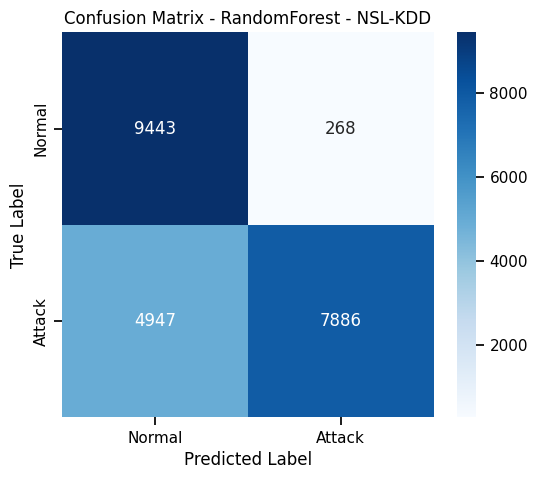

array([1, 1, 0, ..., 1, 0, 1])

In [3]:
from sklearn.ensemble import RandomForestClassifier

# 1. 初始化模型
# n_estimators=100 表示我们要种 100 棵树
# n_jobs=-1 表示动用你 CPU 的所有核来并行加速
# random_state=42 保证每次跑的结果一样（方便复现）
rf_model_nsl = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

print("🚀 开始训练 NSL-KDD 随机森林模型 (请稍候)...")

# 2. 训练 (Fit) - 这一步就是让模型“刷题”，学习 X_train 和 y_train 的关系
rf_model_nsl.fit(X_train_nsl, y_train_nsl)
print("✅ 训练完成！")

# 3. 评估 (Evaluate) - 调用我们在 P2 写的工具
# 注意：这里我们传入的是 X_test_nsl，让模型做“期末考试”
evaluate_model(rf_model_nsl, X_test_nsl, y_test_nsl, model_name="RandomForest - NSL-KDD")

检查训练集表现 (Training Set Performance)...

==================== EVALUATION: RF - NSL-KDD (Train Set) ====================
⏱️ Inference Time: 0.4990 sec
🏆 Accuracy: 0.9999

📝 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9999    1.0000    0.9999     60608
      Attack     1.0000    0.9999    0.9999     52767

    accuracy                         0.9999    113375
   macro avg     0.9999    0.9999    0.9999    113375
weighted avg     0.9999    0.9999    0.9999    113375



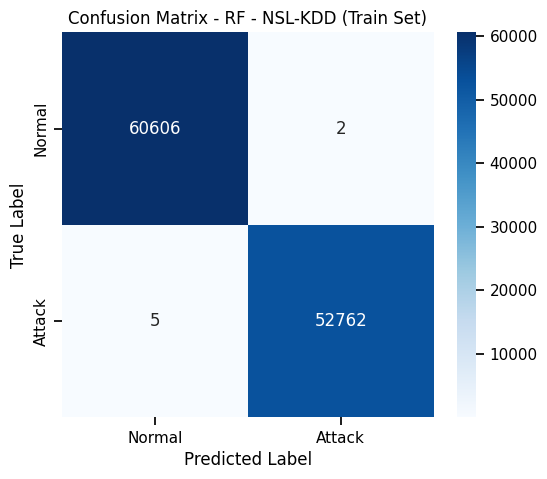

array([0, 0, 1, ..., 0, 0, 1])

In [4]:
# 看看在做过的“练习题”上表现如何
print("检查训练集表现 (Training Set Performance)...")
evaluate_model(rf_model_nsl, X_train_nsl, y_train_nsl, model_name="RF - NSL-KDD (Train Set)")


🚀 [P4] 开始训练 CIC-IDS-2017 随机森林模型...
📊 训练集规模: (1764525, 51)
⚠️ 注意：由于数据量达 170万+，训练可能需要 2-5 分钟，请耐心等待...
✅ 训练完成！耗时: 195.57 秒

==================== EVALUATION: RandomForest - CIC-IDS ====================
⏱️ Inference Time: 1.3365 sec
🏆 Accuracy: 0.9987

📝 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9992    0.9992    0.9992    419012
      Attack     0.9959    0.9963    0.9961     85139

    accuracy                         0.9987    504151
   macro avg     0.9975    0.9977    0.9976    504151
weighted avg     0.9987    0.9987    0.9987    504151



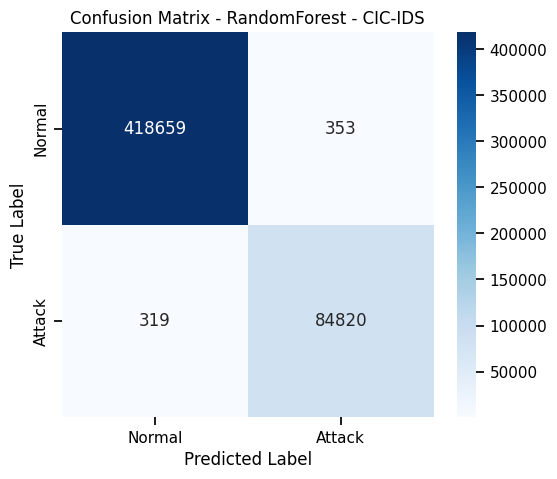

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
from sklearn.ensemble import RandomForestClassifier
import time

# --- P4: CIC-IDS-2017 基线训练 ---

print(f"\n🚀 [P4] 开始训练 CIC-IDS-2017 随机森林模型...")
print(f"📊 训练集规模: {X_train_cic.shape}")
print(f"⚠️ 注意：由于数据量达 170万+，训练可能需要 2-5 分钟，请耐心等待...")

# 1. 初始化模型
# n_estimators=50: 稍微降低一点树的数量以换取速度
# n_jobs=-1: 必开，调用所有 CPU 核心
# class_weight='balanced': (可选) 这行代码可以自动处理不平衡，但为了看“原始”表现，我们先注释掉，Day 12 再用
rf_model_cic = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

# 2. 训练 (Fit)
start_time = time.time()
rf_model_cic.fit(X_train_cic, y_train_cic)
train_time = time.time() - start_time
print(f"✅ 训练完成！耗时: {train_time:.2f} 秒")

# 3. 评估 (Evaluate)
# 直接调用之前写好的工具函数
# 注意：CIC-IDS 的测试集也有 50万+ 条，推理也需要几秒钟
evaluate_model(rf_model_cic, X_test_cic, y_test_cic, model_name="RandomForest - CIC-IDS")

In [6]:
import joblib
import os

print(f"💾 开始保存模型文件...")

# 1. 保存 NSL-KDD 模型
# 压缩级别 compress=3 可以节省一些磁盘空间
joblib.dump(rf_model_nsl, 'rf_nsl_kdd_baseline.joblib', compress=3)
print(f"✅ NSL-KDD 模型已保存至: {os.path.abspath('rf_nsl_kdd_baseline.joblib')}")

# 2. 保存 CIC-IDS 模型 (这个文件会比较大，几百MB是正常的)
joblib.dump(rf_model_cic, 'rf_cic_ids_baseline.joblib', compress=3)
print(f"✅ CIC-IDS 模型已保存至: {os.path.abspath('rf_cic_ids_baseline.joblib')}")

# 3. 验证一下文件是否真的存在
print("\n📂 当前目录文件列表:")
print(os.listdir('.'))

💾 开始保存模型文件...
✅ NSL-KDD 模型已保存至: /kaggle/working/rf_nsl_kdd_baseline.joblib
✅ CIC-IDS 模型已保存至: /kaggle/working/rf_cic_ids_baseline.joblib

📂 当前目录文件列表:
['.virtual_documents', 'rf_nsl_kdd_baseline.joblib', 'rf_cic_ids_baseline.joblib']
